<a href="https://colab.research.google.com/github/Intertangler/ML4biotech/blob/main/neural_network_training_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext rpy2.ipython

## exercise - training neural networks
In this exercise we have an artificial dataset of gene expression values for multiple individuals and 16 different genes. The data were generated such as to have a class label or "outcome" variable that we might say cooresponds to a physiological outcome (e.g. pathological status or not). The goal of this exercise is to get a little practical experience diagnosing some common issues with training neural networks when trying to get good performance. Start by running the two cells below to import the expression data and visualize with histograms.

In [ ]:
%%R
install.packages("readr")
install.packages("dplyr")
install.packages("tidyr")

In [ ]:
%%R
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)


#import csv gene expression data
github_url <- "https://raw.githubusercontent.com/Intertangler/ML4biotech/main/gene_data_complex.csv"
df <- read_csv(github_url, col_types = cols())


n_individuals <- nrow(df)
n_genes <- 16
outcome <- df$outcome
gene_data <- list()

for (gene_idx in 0:(n_genes - 1)) {
  gene_data[[gene_idx + 1]] <- list(
    expression = df[[paste0("gene_", gene_idx, "_expression")]],
    on_state = as.logical(df[[paste0("gene_", gene_idx, "_on_state")]])
  )
}

# plot histograms of the expression for each gene
for (idx in 1:n_genes) {
  expression <- gene_data[[idx]]$expression
  data_for_plot <- data.frame(expression = expression)


  p1 <- ggplot(data_for_plot, aes(x = expression)) +
    geom_histogram(fill = "blue", color = "black") +
    ggtitle(paste("Gene", idx, "Normal Scale"))


  p2 <- ggplot(data_for_plot, aes(x = expression)) +
    geom_histogram(fill = "green",  color = "black") +
    scale_y_log10() +
    ggtitle(paste("Gene", idx, "Log Scale"))

  print(p1)
  print(p2)
}



## scaling gene expression data

In order to have the input data on the correct scale, we will squash it into a range from 0 to 1. This process is called normalization.

In [ ]:
%%R

library(ggplot2)

all_gene_expressions <- matrix(0, nrow = n_individuals, ncol = n_genes)

for (gene_idx in 1:n_genes) {
  all_gene_expressions[, gene_idx] <- gene_data[[gene_idx]]$expression
}

log_gene_expressions <- log1p(all_gene_expressions)

# Min-Max Scaling
min_val <- apply(log_gene_expressions, 2, min)
max_val <- apply(log_gene_expressions, 2, max)
scaled_gene_expressions <- sweep(log_gene_expressions, 2, min_val, FUN = "-")
scaled_gene_expressions <- sweep(scaled_gene_expressions, 2, max_val - min_val, FUN = "/")
max_scaled_expression <- max(scaled_gene_expressions)


x_scaled_range <- seq(0, max_scaled_expression, length.out = 50)
#  plots
for (idx in 1:n_genes) {
  scaled_expression <- scaled_gene_expressions[, idx]
  data_for_plot <- data.frame(scaled_expression = scaled_expression)

  p1 <- ggplot(data_for_plot, aes(x = scaled_expression)) +
    geom_histogram(breaks = x_scaled_range, fill = "blue", alpha = 0.7, color = "black") +
    ggtitle(paste("Gene", idx, "Scaled"))

  p2 <- ggplot(data_for_plot, aes(x = scaled_expression)) +
    geom_histogram(breaks = x_scaled_range, fill = "green", alpha = 0.7, color = "black") +
    scale_y_log10() +
    ggtitle(paste("Gene", idx, "Log Scaled"))
  print(p1)
  print(p2)
}


### underperforming neural network 1
Examine the code below and try to diagnose the problem with this currently under-performing network. Utilize your understanding of the data that is being analyzed, the techniques commonly employed during training, and experimentation to figure out what is going on.

In [ ]:
%%R
install.packages("keras")
install.packages("caTools")
install.packages("pROC")

Epoch 1 - loss: 1.15136754512787 
Epoch 11 - loss: 1.10216569900513 
Epoch 21 - loss: 1.05730926990509 
Epoch 31 - loss: 1.01518404483795 
Epoch 41 - loss: 0.975581228733063 
Epoch 51 - loss: 0.939543068408966 
Epoch 61 - loss: 0.90616899728775 
Epoch 71 - loss: 0.874955952167511 
Epoch 81 - loss: 0.846981108188629 
Epoch 91 - loss: 0.822503328323364 


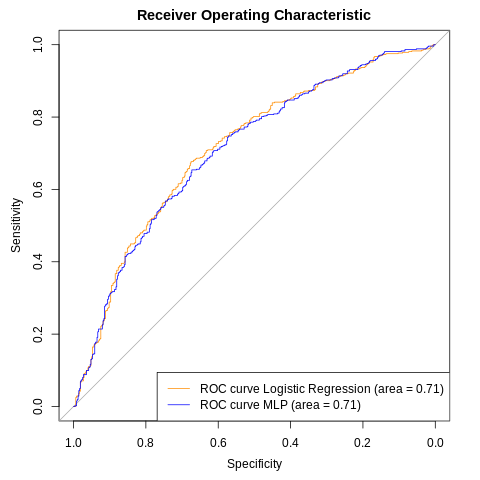

In [ ]:
%%R

library(keras)
library(caTools)
library(pROC)

# Split
set.seed(1234)
spl = sample.split(outcome, SplitRatio = 0.5)
X_train = scaled_gene_expressions[spl,]
y_train = outcome[spl]
X_test = scaled_gene_expressions[!spl,]
y_test = outcome[!spl]

#  logistic model for comparison
logistic_model <- glm(y_train ~ ., data = data.frame(X_train, y_train), family = "binomial")
y_score <- predict(logistic_model, newdata = data.frame(X_test), type = "response")
roc_obj_mlp <- roc(y_test, y_score_mlp)
roc_auc_mlp <- auc(roc_obj_mlp)


# neural network architecture part
model <- keras_model_sequential() %>%
  layer_dense(units = 32, input_shape = ncol(X_train), activation = 'relu', kernel_regularizer = regularizer_l1(0.005)) %>%
  layer_dense(units = 1, activation = 'sigmoid')

# compile the model using adaptive moment estimation optimizer adam
optimizer <- optimizer_adam(learning_rate = 0.0001)
model %>% compile(
  loss = 'binary_crossentropy',
  optimizer = optimizer
)

# callback to print loss every 10 epochs
print_loss_callback <- callback_lambda(on_epoch_end = function(epoch, logs) {
  if (epoch %% 10 == 0) {
    cat(paste("Epoch", epoch + 1, "- loss:", logs$loss, "\n"))
  }
})

# Train the model
history <- model %>% fit(
  x = X_train,
  y = y_train,
  epochs = 100,
  verbose = 0,
  callbacks = list(print_loss_callback),
  validation_split = 0.2
)

y_score_mlp <- as.numeric(y_score_mlp)
roc_obj_mlp <- roc(y_test, y_score_mlp)
roc_auc_mlp <- auc(roc_obj_mlp)

#  ROC curve
plot.roc(roc_obj, col = "darkorange", lwd = 1, main = "Receiver Operating Characteristic")
lines(roc_obj_mlp, col = "blue", lwd = 1)
legend("bottomright", legend = c(paste("ROC curve Logistic Regression (area = ", round(roc_auc, 2), ")", sep = ""),
                                paste("ROC curve MLP (area = ", round(roc_auc_mlp, 2), ")", sep = "")),
       col = c("darkorange", "blue"), lty = 1)


Epoch 1 - loss: 0.692876875400543 
Epoch 11 - loss: 0.672750234603882 
Epoch 21 - loss: 0.570795893669128 
Epoch 31 - loss: 0.503940165042877 
Epoch 41 - loss: 0.463290512561798 
Epoch 51 - loss: 0.432485312223434 
Epoch 61 - loss: 0.393106818199158 
Epoch 71 - loss: 0.367178320884705 
Epoch 81 - loss: 0.345430314540863 
Epoch 91 - loss: 0.339910686016083 
Epoch 101 - loss: 0.32172092795372 
Epoch 111 - loss: 0.296262711286545 
Epoch 121 - loss: 0.280050992965698 
Epoch 131 - loss: 0.273112207651138 
Epoch 141 - loss: 0.255866199731827 
Epoch 151 - loss: 0.247725114226341 
Epoch 161 - loss: 0.242658168077469 
Epoch 171 - loss: 0.244269415736198 
Epoch 181 - loss: 0.225899785757065 
Epoch 191 - loss: 0.217497870326042 
Epoch 201 - loss: 0.239758193492889 
Epoch 211 - loss: 0.210678696632385 
Epoch 221 - loss: 0.20543010532856 
Epoch 231 - loss: 0.192451387643814 
Epoch 241 - loss: 0.174452930688858 
Epoch 251 - loss: 0.169574618339539 
Epoch 261 - loss: 0.174873441457748 
Epoch 271 - lo

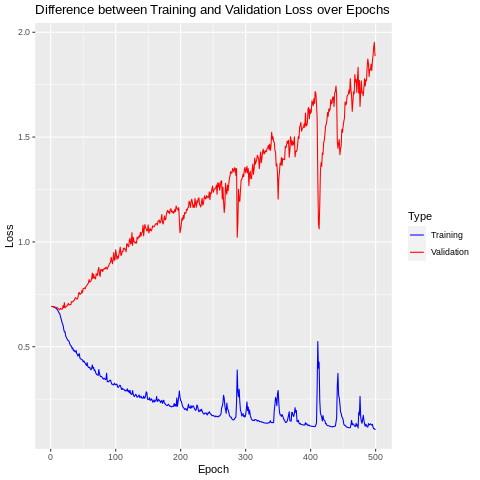

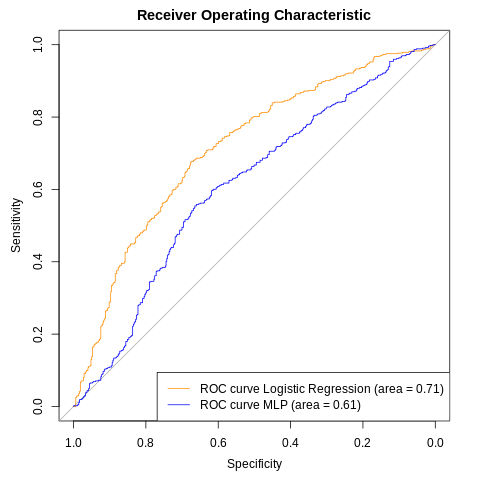

In [ ]:
%%R
library(caTools)
library(pROC)
library(keras)
library(ggplot2)

set.seed(1234)

spl <- sample.split(outcome, SplitRatio = 0.5)
X_train <- scaled_gene_expressions[spl,]
y_train <- outcome[spl]
X_test <- scaled_gene_expressions[!spl,]
y_test <- outcome[!spl]

# logistic model
logistic_model <- glm(y_train ~ ., data = data.frame(X_train, y_train), family = "binomial")
y_score <- predict(logistic_model, newdata = data.frame(X_test), type = "response")
roc_obj <- roc(y_test, y_score)
roc_auc <- auc(roc_obj)

# model arrchitecture
model <- keras_model_sequential() %>%
  layer_dense(units = 10, input_shape = ncol(X_train), activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 10, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile
optimizer <- optimizer_adam(learning_rate = 0.001)
model %>% compile(
  loss = 'binary_crossentropy',
  optimizer = optimizer
)

#  callback
print_loss_callback <- callback_lambda(on_epoch_end = function(epoch, logs) {
  if (epoch %% 10 == 0) {
    cat(paste("Epoch", epoch + 1, "- loss:", logs$loss, "\n"))
  }
})

# Train
history <- model %>% fit(
  x = X_train,
  y = y_train,
  epochs = 500,
  verbose = 0,
  callbacks = list(print_loss_callback),
  validation_split = 0.5
)


train_loss <- history$metrics$loss
val_loss <- history$metrics$val_loss
df <- data.frame(
  Epoch = rep(1:length(train_loss), 2),
  Loss = c(train_loss, val_loss),
  Type = factor(rep(c("Training", "Validation"), each = length(train_loss)))
)

p <- ggplot(df, aes(x = Epoch, y = Loss, color = Type)) +
  geom_line() +
  ggtitle("Difference between Training and Validation Loss over Epochs") +
  xlab("Epoch") +
  ylab("Loss") +
  scale_color_manual(values = c("Training" = "blue", "Validation" = "red"))

# plot
print(p)

# ROC curve
y_score_mlp <- model %>% predict(X_test) %>% as.vector()
roc_obj_mlp <- roc(y_test, y_score_mlp)
roc_auc_mlp <- auc(roc_obj_mlp)
plot.roc(roc_obj, col = "darkorange", lwd = 1, main = "Receiver Operating Characteristic")
lines(roc_obj_mlp, col = "blue", lwd = 1)
legend("bottomright", legend = c(paste("ROC curve Logistic Regression (area = ", round(roc_auc, 2), ")", sep = ""),
                                paste("ROC curve MLP (area = ", round(roc_auc_mlp, 2), ")", sep = "")),
       col = c("darkorange", "blue"), lty = 1)


### underperforming network 3
In this network, early stopping, dropout layers, and minibatch sampling have been added. Can you figure out what is wrong with the model?

In [ ]:
%%R
library(keras)
library(caTools)
library(pROC)
library(ggplot2)

set.seed(1234)
spl <- sample.split(outcome, SplitRatio = 0.5)
X_train <- scaled_gene_expressions[spl, ]
y_train <- outcome[spl]
X_test <- scaled_gene_expressions[!spl, ]
y_test <- outcome[!spl]

# model architecture
model <- keras_model_sequential() %>%
  layer_dense(units = 800, input_shape = ncol(X_train), activation = 'relu') %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 1, activation = 'sigmoid')

# Compile
optimizer <- optimizer_adam(learning_rate = 0.05)
model %>% compile(
  loss = 'binary_crossentropy',
  optimizer = optimizer
)

#  callback
print_loss_callback <- callback_lambda(on_epoch_end = function(epoch, logs) {
  if (epoch %% 10 == 0) {
    cat(paste("Epoch", epoch + 1, "- loss:", logs$loss, "\n"))
  }
})

# Train
early_stop <- callback_early_stopping(monitor = "val_loss", patience = 20, restore_best_weights = TRUE)
history <- model %>% fit(
  x = X_train,
  y = y_train,
  epochs = 1000,
  batch_size = 32,
  verbose = 0,
  callbacks = list(print_loss_callback, early_stop),
  validation_split = 0.5
)


train_loss <- history$metrics$loss
val_loss <- history$metrics$val_loss
df <- data.frame(
  Epoch = rep(1:length(train_loss), 2),
  Loss = c(train_loss, val_loss),
  Type = factor(rep(c("Training", "Validation"), each = length(train_loss)))
)

p <- ggplot(df, aes(x = Epoch, y = Loss, color = Type)) +
  geom_line() +
  ggtitle("Difference between Training and Validation Loss over Epochs") +
  xlab("Epoch") +
  ylab("Loss") +
  scale_color_manual(values = c("Training" = "blue", "Validation" = "red"))

print(p)

y_score_mlp <- model %>% predict(X_test) %>% as.vector()
y_pred_mlp <- ifelse(y_score_mlp > 0.5, 1, 0)
roc_obj_mlp <- roc(y_test, y_score_mlp)
roc_auc_mlp <- auc(roc_obj_mlp)

plot.roc(roc_obj, col = "darkorange", lwd = 1, main = "Receiver Operating Characteristic")
lines(roc_obj_mlp, col = "blue", lwd = 1)
legend("bottomright", legend = c(paste("ROC curve Logistic Regression (area = ", round(roc_auc, 2), ")", sep = ""),
                                paste("ROC curve MLP (area = ", round(roc_auc_mlp, 2), ")", sep = "")),
       col = c("darkorange", "blue"), lty = 1)
